# Las Vegas 用户相似度计算

### 该 Notebook 对应的博客[链接](http://xiehongfeng100.github.io/2018/07/31/yelper-dpps-las-vegas-data-preprocessing/)

用户之间的相似度是通过计算他们之间共同评价过的商店的 stars 值来计算的，计算公式如下：
$$
similarity(A,B)=\frac{A\cdot B}{\left \| A \right \|\left \| B \right \|} =\frac{\sum_{n}^{i}A_{i}\times B_{i}}{\sqrt{\sum_{n}^{i}A_{i}^{2}}\times \sqrt{\sum_{n}^{i}B_{i}^{2}}}
$$

如用户 A 和 B 共同评价过 Business1、Business2、Business3，而且他们对这三个 business 给出的 stars 分别为 $ \overrightarrow{A}=< 5, 3, 3 > $, $ \overrightarrow{B}=< 4, 2, 3 > $，那他们之间的相似度为：

$$
similarity(A,B)=\frac {5*4 + 3*2 + 3*3}{\sqrt{5^{2}+3^{2}+3^{2}}\times \sqrt{4^{2}+2^{2}+3^{2}}}=\frac{35}{\sqrt{43}*\sqrt{29}} \approx 0.99
$$

但这里我们有**三个细节**需要注意的：

- `只要用户 A 和 B 只共同评价过一个 business，那他们的相似度就为 1，这显然是不大合常理的，所以这种情况要剔除掉。`

- 当用户 A 和 B 共同评价过某些 business，即使他们给的 stars 都很低，他们之间的相似度可能也会比较高，如 $ \overrightarrow{A}=< 1, 1 > $, $ \overrightarrow{B}=< 1, 1 > $，此时计算出来 A、B 的相似度为 1，这也是不合常理的。`既然用户都不喜欢某一家 business，那他们的相似度不应该高;相似度高的应该是对某些 business 都给过比较高评价的用户。所以在计算用户相似度时，会剔除掉 stars 值低于 3 的评论。`

- 用户 A 和 B 对同一家 business 都给出比较高的评价，但是 A 和 B 对该 business 评价的时间差较大，如 A 在 5 年前给该 business 评了 5 分，B 在今年对它评价了 5 分，直接计算可能会得到较高的相似度。这样得出来的结果也是不大合常理的，因为`时间相隔太久，用户的兴趣可能已经千变万化，所以在计算相似度时还要乘上一个时间衰减函数`，如我们可以定义该函数为：

$$
f(\delta) = \frac {1}{1 + \alpha * \delta}
$$

其中，$\delta$ 表示两个 review 之间时间差；$\alpha$ 表示衰减系数，值越大衰减的越厉害。关于其图形请见本文后边说明。

综上，可以得到**最终的用户相似度公式**为：

$$
similarity(A,B)=\frac{A\cdot B \cdot F(\delta)}{\left \| A \right \|\left \| B \right \|} =\frac{\sum_{n}^{i}A_{i}\times B_{i} \times f(\delta_{i})}{\sqrt{\sum_{n}^{i}A_{i}^{2}}\times \sqrt{\sum_{n}^{i}B_{i}^{2}}}
$$

# 实际计算过程

In [1]:
import math
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt

## 1. 加载数据

In [2]:
yelp_lv_rvs = pd.read_csv('../../dataset/las_vegas/las_vegas_review_with_stars_time_scaled_with_db_id.csv')

In [3]:
len(yelp_lv_rvs)

1604246

In [4]:
yelp_lv_rvs[:5]

,db_id,review_id,user_db_id,business_db_id,stars,year,stars_time_scaled
0,3,---3OXpexMp0oAg77xWfYA,999269,92729,5,2012,2.500000
1,6,---94vtJ_5o_nikEs6hUjg,313272,122971,5,2014,4.403985
2,8,---D6-P4MpS86LYldBfX7w,735101,160943,4,2016,3.928055
3,20,---WDP9kwKyVQiw9GTgNmQ,1045600,12131,1,2014,0.880797
4,22,---zHMCae68gIbSbtXxD5w,971613,15470,4,2015,3.810297


** 过滤掉 stars_time_scaled 小于 3 的 review **

In [5]:
yelp_lv_rvs = yelp_lv_rvs[yelp_lv_rvs.stars_time_scaled >= 3]

In [6]:
len(yelp_lv_rvs)

819669

## 2. 计算 User2Business 映射

In [7]:
lv_users = yelp_lv_rvs.user_db_id.unique()

In [8]:
len(lv_users)

330109

In [9]:
def calc_user_bizes(user):
    user_bizes = dict()
    user_bizes[user] = dict()
    rvs = yelp_lv_rvs[yelp_lv_rvs.user_db_id==user]
    for index, row in rvs.iterrows():
        biz = row['business_db_id']
        user_bizes[user][biz] = dict(stars_time_scaled=row['stars_time_scaled'], year=row['year'])
    return user_bizes

这里为了更好利用计算机并发能力（12核），利用多进程库 [multiprocessing](https://docs.python.org/2/library/multiprocessing.html) 进程池来加快计算

In [10]:
%%time
pool = mp.Pool(processes=12)
user_bizes = pool.map(calc_user_bizes, lv_users)
pool.close()
pool.join()

CPU times: user 4.8 s, sys: 340 ms, total: 5.14 s
Wall time: 1min 6s


In [11]:
lv_user_biz_maps = {user_biz.keys()[0]: user_biz.values()[0] for user_biz in user_bizes}

In [12]:
lv_user_biz_maps[76887]

{5813: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 26820: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 62410: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 105514: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 123345: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 124443: {'stars_time_scaled': 4.762870634112167, 'year': 2015},
 148480: {'stars_time_scaled': 3.8102965072897335, 'year': 2015},
 154973: {'stars_time_scaled': 4.762870634112167, 'year': 2015}}

## 3. Calculate User2User Similarities

### 3.1 定义时间衰减函数

In [13]:
alpha = 1.0 # 这里我们取 alpha 为 1.0
def time_attenuation(delta):
    return 1 / (1 + alpha * abs(delta))

Text(0,0.5,'$f(\\delta)$')

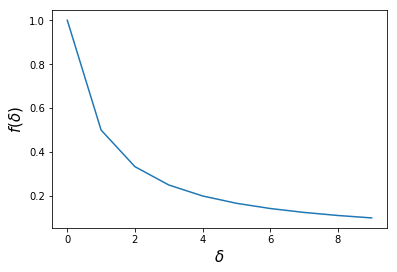

In [14]:
# 看一下时间衰减函数的图形
x = np.arange(10)
y = time_attenuation(x)
plt.plot(x, y)
plt.xlabel(r'$\delta$', fontsize=15); plt.ylabel(r'$f(\delta)$', fontsize=15)

### 3.2 相似度“多进程”计算概述

当计算用户 A 与 B 之间的相似度时，如果**简单**直接使用两重 for 循环计算，我们最后会得到两个相似度 similarity(A, B) 及 similarity(B, A)，而这两者不管是意义还是值大小上都是相等的，`最好的情况下只需计算一个。`**如果我们使用单进程，这没有什么问题，因为不存在共享变量的问题；但如果我们要用多进程来加快计算速度，涉及到共享变量的问题，那我们就需要在速度和重复计算中做一个折中。**详细请看下边实验。

#### 3.2.1 采用共享变量

因为使用多进程来加快计算用户之间的相似度，可以用 multiprocessing.Manager 来定义多进程之间的共享变量，以达到不用重复计算的效果。大概代码如下：

````Python
from multiprocessing import Manager
manager = Manager()
calulated_u2u_simis = manager.dict()

# 多进程计算用户相似度
def calc_similarity(user_a):
    user_similarities = list()
    bizes_a = lv_user_biz_maps[user_a]
    for user_b in lv_users[:50]:
        if user_a == user_b:
            continue
        if (user_a, user_b) in calulated_u2u_simis or (user_b, user_a) in calulated_u2u_simis: # 1. 已经计算过的直接跳过
            continue
        bizes_b = lv_user_biz_maps[user_b]
        similarity = _calc_similarity(bizes_a, bizes_b) # 该函数定义在后边
        if similarity:
            user_similarities.append([user_a, user_b, similarity])
            # 2. 设置共享变量
            calulated_u2u_simis[(user_a, user_b)] = True

    return user_similarities

pool = mp.Pool(processes=12)
u2u_similarities = pool.map(calc_similarity, lv_users)
pool.close()
pool.join()
````

理想很丰满，现实很残酷！让我们来看一下多进程利用率吧：

![多进程利用率](images/multiprocessing_manager_lock.png)  

也就是说，multiprocessing.Manger 其实在共享变量 calulated_u2u_simis 上加了一个锁，导致我们无法充分利用多核优势。关于加锁，目前在官方文档还没找到描述的地方，不过可以参考一个 StackOverflow 网友的[实验](https://stackoverflow.com/a/47875528)，他证明了使用 multiprocessing.Manger.dict() 会加锁。

另外关于 multiprocessing 详细可参考[官方文档](https://docs.python.org/2/library/multiprocessing.html#managers)，[博文](https://my.oschina.net/leejun2005/blog/203148)。

#### 3.2.2 不设置共享变量（接下来的计算会采用该方式）

这是比较简单的做法，对于用户 A 与 B，我们会计算两个相似度 similarity(A, B) 及 similarity(B, A)，最后再通过额外处理过滤掉重复的相似度。虽然存在重复计算的问题，但我们可以利用多核优势，加快计算。此时的多核利用率如下图所示：

![多进程利用率](images/multiprocessing_with_no_share_variable.png)  

In [15]:
# from multiprocessing import Manager

In [16]:
# manager = Manager()
# calulated_u2u_simis = manager.dict()
# calulated_u2u_simis = dict()

### 3.2 计算相似度

In [17]:
def _calc_similarity(bizes_a, bizes_b):
    similarity = 0
    comm_bizes = set(bizes_a.keys()) & set(bizes_b.keys()) # 共同评价过的 business
    if len(comm_bizes) < 2: # 过滤掉用户之间只共同评价过一个 business 的情况
        return similarity

    bizes_ab_product = 0
    biz_a_length = 0
    biz_b_length = 0
    for biz in comm_bizes:
        stars_a = bizes_a[biz]['stars_time_scaled']
        stars_b = bizes_b[biz]['stars_time_scaled']
        year_a = bizes_a[biz]['year']
        year_b = bizes_b[biz]['year']
        bizes_ab_product += stars_a * stars_b * time_attenuation(year_a - year_b) # 乘以时间衰减函数
        biz_a_length += pow(stars_a, 2)
        biz_b_length += pow(stars_b, 2)

    similarity = bizes_ab_product / (math.sqrt(biz_a_length) * math.sqrt(biz_b_length))
    return similarity

In [18]:
def calc_similarity(user_a):
    user_similarities = list()
    bizes_a = lv_user_biz_maps[user_a]
    for user_b in lv_users:
        if user_a == user_b:
            continue
#         if (user_a, user_b) in calulated_u2u_simis or (user_b, user_a) in calulated_u2u_simis: # 已经计算过的直接跳过
#             continue
        bizes_b = lv_user_biz_maps[user_b]
        similarity = _calc_similarity(bizes_a, bizes_b)
        if similarity:
            user_similarities.append([user_a, user_b, similarity])
            # 设置共享变量
            # calulated_u2u_simis[(user_a, user_b)] = True

    return user_similarities

In [19]:
%%time
pool = mp.Pool(processes=12)
u2u_similarities = pool.map(calc_similarity, lv_users)
pool.close()
pool.join()

CPU times: user 25.9 s, sys: 4.48 s, total: 30.4 s
Wall time: 4h 55min 43s


## 4. 处理重复数据及保存数据

### 4.1 数据聚合

In [20]:
all_u2u_similarities = list()
for similarities in u2u_similarities:
    all_u2u_similarities.extend(similarities)

In [21]:
len(all_u2u_similarities)

6768590

In [22]:
all_u2u_similarities[:5]

[[313272, 971613, 0.7128247382890718],
 [313272, 919085, 0.4974513327262249],
 [313272, 1254779, 0.39954072623395737],
 [313272, 1313322, 0.4969418673368094],
 [313272, 920249, 0.4992845542199113]]

### 4.2 移除重复数据

In [23]:
calculated = dict()

In [24]:
not_repeated = list()
for row in all_u2u_similarities:
    key = (row[0], row[1])
    rkey = (row[1], row[0])
    if key not in calculated and rkey not in calculated:
        not_repeated.append([row[0], row[1], row[2]])
        calculated[key] = True

In [25]:
len(not_repeated)

3384295

### 4.3 保存数据

In [26]:
similarity_df = pd.DataFrame(not_repeated, columns=['user_a_db_id', 'user_b_db_id', 'similarity'])

In [27]:
similarity_df[:5]

,user_a_db_id,user_b_db_id,similarity
0,313272,971613,0.712825
1,313272,919085,0.497451
2,313272,1254779,0.399541
3,313272,1313322,0.496942
4,313272,920249,0.499285


In [28]:
similarity_df.to_csv('../../dataset/las_vegas/las_vegas_user2user_similarities.csv', index=False)